Dataset de ventes généré avec succès.
        date        sales  day_of_week  month  is_weekend
0 2023-01-01  1089.671415            6      1        True
1 2023-01-02   627.453570            0      1       False
2 2023-01-03   787.648854            1      1       False
3 2023-01-04   957.102986            2      1       False
4 2023-01-05   863.624663            3      1       False
5 2023-01-06   946.186304            4      1       False
6 2023-01-07  1372.321282            5      1        True
7 2023-01-08  1131.303473            6      1        True
8 2023-01-09   603.292561            0      1       False
9 2023-01-10   787.216004            1      1       False
       Aperçu des données:
Période: 2023-01-01 00:00:00 à 2024-06-30 00:00:00
Nombre de jours: 547
Ventes moyennes: 1897€
Écart-type: 872€

       Anomalies injectées:
anomaly_type
normal          538
stock_out         3
promotion         3
tech_issue        2
black_friday      1
Name: count, dtype: int64
         Performa

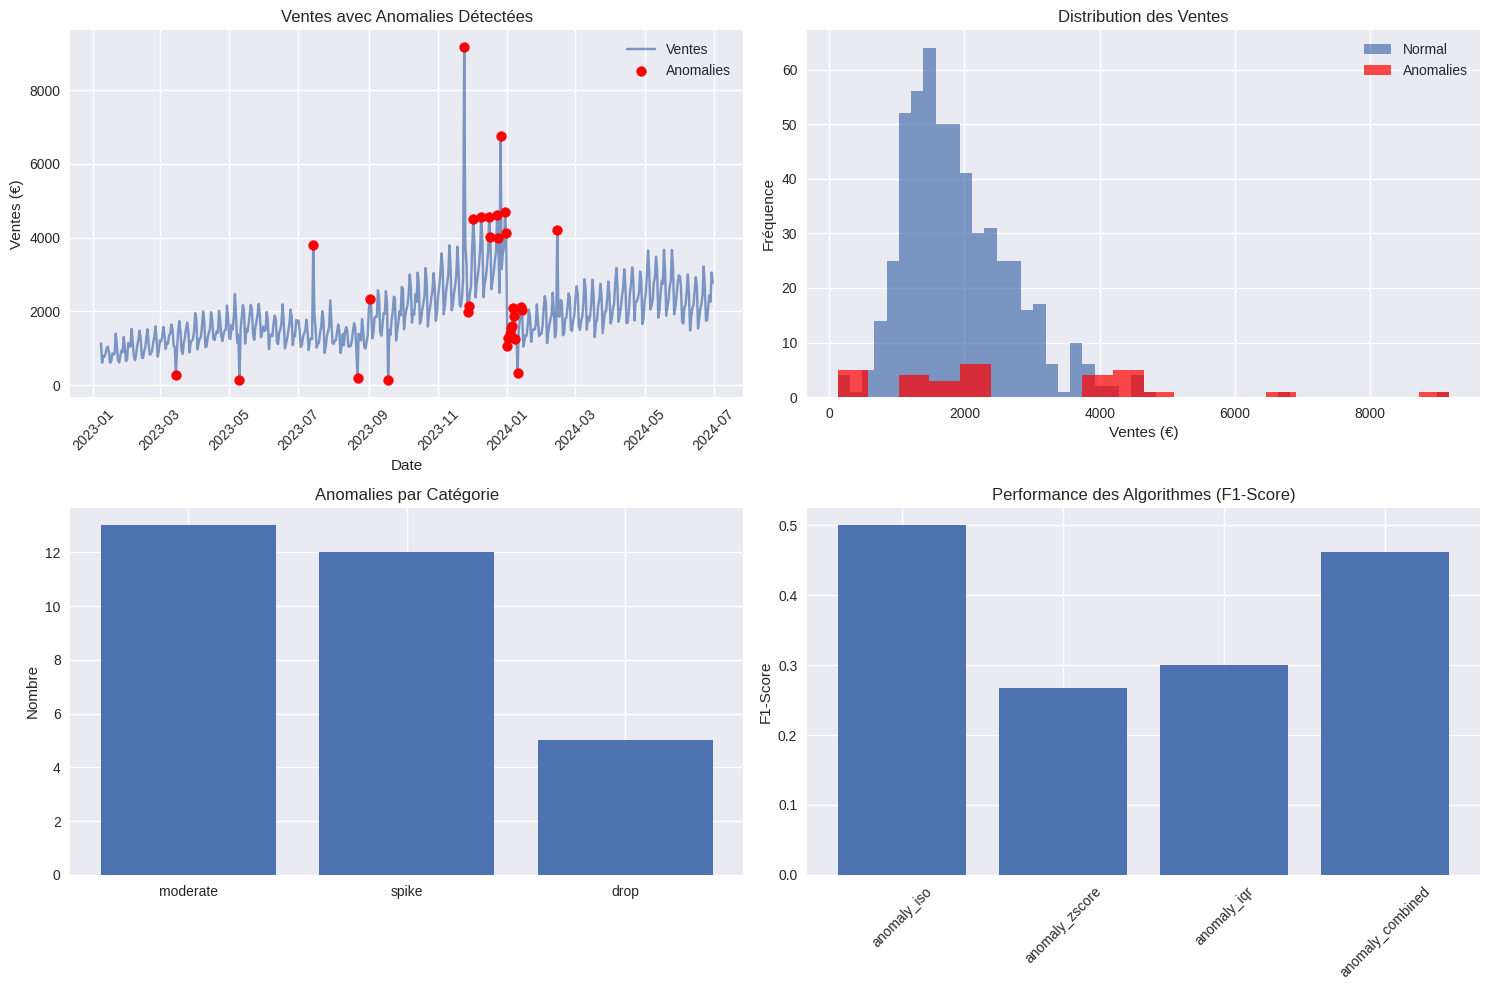

       Système d'Alerte:

CHUTE DÉTECTÉE: 260€ (22.1% vs attendu)
Recommandations:
  • Vérifier les problèmes techniques
  • Contrôler les stocks et approvisionnements
  • Contacter l'équipe marketing pour des actions correctives

CHUTE DÉTECTÉE: 146€ (9.9% vs attendu)
Recommandations:
  • Vérifier les problèmes techniques
  • Contrôler les stocks et approvisionnements
  • Contacter l'équipe marketing pour des actions correctives

VARIATION: 3791€ (2.3x vs attendu)
Recommandations:
  • Surveiller l'évolution sur les prochains jours
  • Analyser les facteurs externes

CHUTE DÉTECTÉE: 198€ (17.1% vs attendu)
Recommandations:
  • Vérifier les problèmes techniques
  • Contrôler les stocks et approvisionnements
  • Contacter l'équipe marketing pour des actions correctives

VARIATION: 2335€ (1.6x vs attendu)
Recommandations:
  • Surveiller l'évolution sur les prochains jours
  • Analyser les facteurs externes


RAPPORT EXÉCUTIF
Détection d'Anomalies - Ventes

RÉSUMÉ EXÉCUTIF
    • Période an

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from sklearn.ensemble import IsolationForest
import warnings
from scipy import stats


warnings.filterwarnings('ignore')

# -------------------------
# PHASE 1 : Préparation des données
# -------------------------

# Génération des données de ventes
np.random.seed(42)
start_date = datetime(2023, 1, 1)
end_date = datetime(2024, 6, 30)
date_range = pd.date_range(start=start_date, end=end_date, freq='D')


# Création du dataset de base
def generate_sales_data(date_range):
    data = []
    for i, date in enumerate(date_range):
        # Tendance de base
        base_sales = 1000 + (i * 2) # Croissance légère

        # Saisonnalité hebdomadaire
        day_of_week = date.weekday()
        weekly_multiplier = [0.8, 0.9, 1.0, 1.1, 1.2, 1.5, 1.3][day_of_week]

        # Saisonnalité mensuelle
        month_multiplier = [0.8, 0.9, 1.0, 1.1, 1.2, 1.0, 0.9, 0.8, 1.1, 1.3, 1.5, 1.8][date.month-1]

        # Bruit aléatoire
        noise = np.random.normal(0, 100)

        # Calcul final
        sales = base_sales * weekly_multiplier * month_multiplier + noise

        data.append({
        'date': date,
        'sales': max(0, sales),
        'day_of_week': day_of_week,
        'month': date.month,
        'is_weekend': day_of_week >= 5
        })

    return pd.DataFrame(data)


df = generate_sales_data(date_range)

print("Dataset de ventes généré avec succès.")
print(df.head(10))

def inject_anomalies(df):
    df_copy = df.copy()

    # Anomalie : Black Friday
    df_copy.loc[df_copy['date'] == pd.to_datetime('2023-11-24'), 'sales'] *= 3
    df_copy.loc[df_copy['date'] == pd.to_datetime('2023-11-24'), 'anomaly_type'] = 'black_friday'

    # Rupture de stock
    stock_out_dates = ['2023-03-15', '2023-08-22', '2024-01-10']
    for date_str in stock_out_dates:
        df_copy.loc[df_copy['date'] == pd.to_datetime(date_str), 'sales'] *= 0.2
        df_copy.loc[df_copy['date'] == pd.to_datetime(date_str), 'anomaly_type'] = 'stock_out'

    # Promotions
    promo_dates = ['2023-07-14', '2023-12-26', '2024-02-14']
    for date_str in promo_dates:
        df_copy.loc[df_copy['date'] == pd.to_datetime(date_str), 'sales'] *= 2.5
        df_copy.loc[df_copy['date'] == pd.to_datetime(date_str), 'anomaly_type'] = 'promotion'

    # Problèmes techniques
    tech_issue_dates = ['2023-05-10', '2023-09-18']
    for date_str in tech_issue_dates:
        df_copy.loc[df_copy['date'] == pd.to_datetime(date_str), 'sales'] *= 0.1
        df_copy.loc[df_copy['date'] == pd.to_datetime(date_str), 'anomaly_type'] = 'tech_issue'

    df_copy['anomaly_type'].fillna('normal', inplace=True)
    return df_copy

df = inject_anomalies(df)


print("       Aperçu des données:")
print(f"Période: {df['date'].min()} à {df['date'].max()}")
print(f"Nombre de jours: {len(df)}")
print(f"Ventes moyennes: {df['sales'].mean():.0f}€")
print(f"Écart-type: {df['sales'].std():.0f}€")

print("\n       Anomalies injectées:")
print(df['anomaly_type'].value_counts())




# -------------------------
# PHASE 2 : Détection IA
# -------------------------

def create_features(df):
    df_features = df.copy()

    # Features temporelles
    df_features['day_of_year'] = df_features['date'].dt.dayofyear
    df_features['week_of_year'] = df_features['date'].dt.isocalendar().week

    # Décalages (lags)
    df_features['sales_lag_1'] = df_features['sales'].shift(1)
    df_features['sales_lag_7'] = df_features['sales'].shift(7)

    # Moyennes mobiles
    df_features['ma_7'] = df_features['sales'].rolling(window=7, min_periods=1).mean()
    df_features['ma_30'] = df_features['sales'].rolling(window=30, min_periods=1).mean()

    # Écarts par rapport aux moyennes
    df_features['deviation_ma_7'] = df_features['sales'] - df_features['ma_7']
    df_features['deviation_ma_30'] = df_features['sales'] - df_features['ma_30']

    # Ratios
    df_features['ratio_ma_7'] = df_features['sales'] / df_features['ma_7']
    df_features['ratio_ma_30'] = df_features['sales'] / df_features['ma_30']

    return df_features

df_features = create_features(df)


# Sélection des features utiles
feature_columns = [
    'sales', 'day_of_week', 'month',
    'deviation_ma_7', 'deviation_ma_30',
    'ratio_ma_7', 'ratio_ma_30'
]

df_clean = df_features.dropna()
X = df_clean[feature_columns]

# Modèle 1 : Isolation Forest
iso_forest = IsolationForest(contamination=0.05, random_state=42)
df_clean['anomaly_iso'] = iso_forest.fit_predict(X)

# Modèle 2 : Z-Score
def detect_anomalies_zscore(data, threshold=3):
    z_scores = np.abs(stats.zscore(data))
    return z_scores > threshold

df_clean['anomaly_zscore'] = detect_anomalies_zscore(df_clean['sales'])

# Modèle 3 : IQR
def detect_anomalies_iqr(data, k=1.5):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - k * IQR
    upper_bound = Q3 + k * IQR
    return (data < lower_bound) | (data > upper_bound)

df_clean['anomaly_iqr'] = detect_anomalies_iqr(df_clean['sales'])

# Combinaison des méthodes
df_clean['anomaly_combined'] = (
    (df_clean['anomaly_iso'] == -1) |
    df_clean['anomaly_zscore'] |
    df_clean['anomaly_iqr']
)


def evaluate_detection(df_clean):
    true_anomalies = df_clean['anomaly_type'] != 'normal'
    methods = ['anomaly_iso', 'anomaly_zscore', 'anomaly_iqr', 'anomaly_combined']
    results = {}

    for method in methods:
        if method == 'anomaly_iso':
            predicted = df_clean[method] == -1
        else:
            predicted = df_clean[method]

        tp = sum(true_anomalies & predicted)
        fp = sum(~true_anomalies & predicted)
        fn = sum(true_anomalies & ~predicted)
        tn = sum(~true_anomalies & ~predicted)

        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

        results[method] = {
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'tp': tp, 'fp': fp, 'fn': fn, 'tn': tn
        }

    return results

performance = evaluate_detection(df_clean)
print("         Performance des algorithmes:")
for method, metrics in performance.items():
    print(f"{method}: Précision={metrics['precision']:.3f}, Rappel={metrics['recall']:.3f}, F1={metrics['f1_score']:.3f}")




# -------------------------
# PHASE 3 : Analyse des anomalies
# -------------------------


# Filtrage des anomalies détectées
anomalies = df_clean[df_clean['anomaly_combined'] == True].copy()

print("           Analyse des anomalies détectées:")
print(f"Nombre d'anomalies: {len(anomalies)}")
print(f"Pourcentage des données: {len(anomalies)/len(df_clean)*100:.1f}%")

# Répartition par type réel
print("\n        Répartition par type réel:")
print(anomalies['anomaly_type'].value_counts())

# Répartition par jour de la semaine
print("\n        Répartition par jour de la semaine:")
print(anomalies['day_of_week'].value_counts().sort_index())

# Répartition par mois
print("\n        Répartition par mois:")
print(anomalies['month'].value_counts().sort_index())

def categorize_anomalies(df_anomalies):
    df_cat = df_anomalies.copy()
    median_sales = df_clean['sales'].median()

    conditions = [
        df_cat['sales'] > median_sales * 2,
        df_cat['sales'] < median_sales * 0.5,
        (df_cat['sales'] >= median_sales * 0.5) & (df_cat['sales'] <= median_sales * 2)
    ]

    choices = ['spike', 'drop', 'moderate']
    df_cat['anomaly_category'] = np.select(conditions, choices, default='unknown')

    return df_cat

anomalies_cat = categorize_anomalies(anomalies)
print("       Catégorisation des anomalies:")
print(anomalies_cat['anomaly_category'].value_counts())


def analyze_causes(df_anomalies):
    causes_analysis = {}

    # Anomalies le week-end
    weekend_anomalies = df_anomalies[df_anomalies['is_weekend'] == True]
    causes_analysis['weekend_effect'] = len(weekend_anomalies) / len(df_anomalies)

    # Saisonnalité (haute saison : nov, déc, janv)
    seasonal_months = [11, 12, 1]
    seasonal_anomalies = df_anomalies[df_anomalies['month'].isin(seasonal_months)]
    causes_analysis['seasonal_effect'] = len(seasonal_anomalies) / len(df_anomalies)

    # Ratio spikes/drops
    spikes = df_anomalies[df_anomalies['anomaly_category'] == 'spike']
    drops = df_anomalies[df_anomalies['anomaly_category'] == 'drop']
    causes_analysis['spike_ratio'] = len(spikes) / len(df_anomalies)
    causes_analysis['drop_ratio'] = len(drops) / len(df_anomalies)

    return causes_analysis

causes = analyze_causes(anomalies_cat)
print("           Analyse des causes:")
for cause, value in causes.items():
    print(f"{cause}: {value:.1%}")

plt.style.use('seaborn-v0_8')
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Graphique 1: Série temporelle avec anomalies
axes[0,0].plot(df_clean['date'], df_clean['sales'], label='Ventes', alpha=0.7)
axes[0,0].scatter(anomalies['date'], anomalies['sales'], color='red', s=50, label='Anomalies', zorder=5)
axes[0,0].set_title('Ventes avec Anomalies Détectées')
axes[0,0].set_xlabel('Date')
axes[0,0].set_ylabel('Ventes (€)')
axes[0,0].legend()
axes[0,0].tick_params(axis='x', rotation=45)

# Graphique 2: Distribution des ventes
axes[0,1].hist(df_clean['sales'], bins=50, alpha=0.7, label='Normal')
axes[0,1].hist(anomalies['sales'], bins=20, alpha=0.7, color='red', label='Anomalies')
axes[0,1].set_title('Distribution des Ventes')
axes[0,1].set_xlabel('Ventes (€)')
axes[0,1].set_ylabel('Fréquence')
axes[0,1].legend()

# Graphique 3: Anomalies par catégorie
anomaly_counts = anomalies_cat['anomaly_category'].value_counts()
axes[1,0].bar(anomaly_counts.index, anomaly_counts.values)
axes[1,0].set_title('Anomalies par Catégorie')
axes[1,0].set_ylabel('Nombre')

# Graphique 4: F1-score des algorithmes
methods = list(performance.keys())
f1_scores = [performance[method]['f1_score'] for method in methods]
axes[1,1].bar(methods, f1_scores)
axes[1,1].set_title('Performance des Algorithmes (F1-Score)')
axes[1,1].set_ylabel('F1-Score')
axes[1,1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


class AnomalyAlertSystem:
    def __init__(self, model, threshold_high=2.5, threshold_low=0.4):
        self.model = model
        self.threshold_high = threshold_high
        self.threshold_low = threshold_low
        self.alerts = []

    def check_daily_sales(self, date, sales_value, expected_sales):
        ratio = sales_value / expected_sales
        alert_level = 'INFO'
        message = f"Ventes normales: {sales_value:.0f}€"

        if ratio > self.threshold_high:
            alert_level = 'HIGH'
            message = f"SPIKE DÉTECTÉ: {sales_value:.0f}€ (x{ratio:.1f} vs attendu)"
        elif ratio < self.threshold_low:
            alert_level = 'CRITICAL'
            message = f"CHUTE DÉTECTÉE: {sales_value:.0f}€ ({ratio:.1%} vs attendu)"
        elif ratio > 1.5 or ratio < 0.7:
            alert_level = 'WARNING'
            message = f"VARIATION: {sales_value:.0f}€ ({ratio:.1f}x vs attendu)"

        alert = {
            'date': date,
            'sales': sales_value,
            'expected': expected_sales,
            'ratio': ratio,
            'level': alert_level,
            'message': message
        }

        self.alerts.append(alert)
        return alert

    def get_recommendations(self, alert):
        recommendations = []
        if alert['level'] == 'HIGH':
            recommendations.extend([
                "Vérifier les campagnes marketing actives",
                "Analyser les stocks pour éviter les ruptures",
                "Capitaliser sur cette tendance positive"
            ])
        elif alert['level'] == 'CRITICAL':
            recommendations.extend([
                "Vérifier les problèmes techniques",
                "Contrôler les stocks et approvisionnements",
                "Contacter l'équipe marketing pour des actions correctives"
            ])
        elif alert['level'] == 'WARNING':
            recommendations.extend([
                "Surveiller l'évolution sur les prochains jours",
                "Analyser les facteurs externes"
            ])
        return recommendations

alert_system = AnomalyAlertSystem(iso_forest)

print("       Système d'Alerte:")
for idx, row in anomalies.head(5).iterrows():
    expected = row['ma_7']
    alert = alert_system.check_daily_sales(row['date'], row['sales'], expected)
    print(f"\n{alert['message']}")

    recommendations = alert_system.get_recommendations(alert)
    if recommendations:
        print("Recommandations:")
        for rec in recommendations:
            print(f"  • {rec}")


def generate_executive_report(df_clean, anomalies_cat, performance):
    report = f"""

RAPPORT EXÉCUTIF
Détection d'Anomalies - Ventes

RÉSUMÉ EXÉCUTIF
    • Période analysée: {df_clean['date'].min().strftime('%d/%m/%Y')} - {df_clean['date'].max().strftime('%d/%m/%Y')}
    • Ventes moyennes: {df_clean['sales'].mean():.0f}€/jour
    • Anomalies détectées: {len(anomalies_cat)} ({len(anomalies_cat)/len(df_clean)*100:.1f}% des jours)
    • Performance système: F1-Score = {performance['anomaly_combined']['f1_score']:.3f}

ANOMALIES PRINCIPALES
    • Spikes (hausses): {len(anomalies_cat[anomalies_cat['anomaly_category'] == 'spike'])} événements
    • Chutes: {len(anomalies_cat[anomalies_cat['anomaly_category'] == 'drop'])} événements
    • Impact moyen: {((anomalies_cat['sales'] - df_clean['sales'].mean()) / df_clean['sales'].mean() * 100).mean():.1f}%

RECOMMANDATIONS
    1. Mettre en place un monitoring quotidien automatique
    2. Créer des protocoles de réaction pour chaque type d'anomalie
    3. Améliorer la prévision des événements promotionnels
    4. Développer des alertes temps réel pour l'équipe commerciale

PROCHAINES ÉTAPES
    • Intégration avec les systèmes de BI existants
    • Formation des équipes sur l'interprétation des alertes
    • Automatisation des actions correctives
"""
    return report

# Affichage du rapport
print(generate_executive_report(df_clean, anomalies_cat, performance))